<a href="https://colab.research.google.com/github/GabyDs/FirearmShotDetectionSystem/blob/main/FirearmShotDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import os
from google.colab import drive

import json
import math
import numpy as np
import pandas as pd
import csv

import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt

import librosa, librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from tensorflow import keras

# Dataset

In [ ]:
!wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t" -O audios.zip

In [ ]:
!unzip audios.zip

In [4]:
os.remove('/content/Audios_disparos_selva/train/fondo/603EFD8C.WAV')
os.remove('/content/Audios_disparos_selva/train/fondo/603EEE5A.WAV')

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


# Explore Dataset

## Auxiliaries functions

In [6]:
FRAME_LENGTH = 1024
HOP_LENGTH = FRAME_LENGTH//2
N_MELS = 40
N_MFCC = 5

In [7]:
def extract_fft(signal):
  signal_fft = sp.fft.fft(signal, FRAME_LENGTH)
  signal_mag = np.abs(signal_fft)

  return signal_fft, signal_mag

In [8]:
def extract_spectrogram(signal):
  return np.abs(librosa.stft(signal,
                             n_fft=FRAME_LENGTH,
                             hop_length=HOP_LENGTH))

In [9]:
def extract_mel_spectrogram(signal, sr):
  signal_mel_spectrogram = librosa.feature.melspectrogram(y=signal,
                                                          sr=sr,
                                                          n_fft=FRAME_LENGTH,
                                                          hop_length=HOP_LENGTH,
                                                          n_mels=N_MELS)

  signal_log_mel_spectrogram = librosa.power_to_db(signal_mel_spectrogram)

  return signal_log_mel_spectrogram

In [10]:
def extract_mfccs(signal, sr):
  mfccs = librosa.feature.mfcc(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, n_mfcc=N_MFCC, sr=sr)
  return mfccs

In [11]:
def plot_fft(signal, sr, audio_type=None):
  signal_fft, signal_mag = extract_fft(signal)

  frequency = np.linspace(0, sr, len(signal_fft))
  f_bins = FRAME_LENGTH//2 + 1

  plt.figure(figsize=(8, 4))
  plt.plot(frequency[:f_bins], signal_mag[:f_bins])

  plt.xlabel('Frequency [Hz]')
  plt.ylabel('Amplitude')
  plt.title(f'Frequency domain spectrum to {audio_type}')
  plt.show()

In [12]:
def plot_spectrogram(signal, y_axis='linear', audio_type=None):
  spectrogram = extract_spectrogram(signal)

  if y_axis == 'log':
    spectrogram = librosa.amplitude_to_db(spectrogram)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(spectrogram,
                           y_axis=y_axis,
                           x_axis='time')

  plt.title(f'Spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()


In [13]:
def plot_mel_spectrogram(signal, sr, audio_type=None):
  mel_spectrogram = extract_mel_spectrogram(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mel_spectrogram,
                           y_axis='mel',
                           x_axis='time')

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()

In [14]:
def plot_mfcc(signal, sr, audio_type=None):
  mfccs = extract_mfccs(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mfccs,
                         x_axis="time",
                         sr=sr)

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.ylabel('Coefficients')
  plt.colorbar(format="%+2.f")
  plt.show()

## Load audios names

In [15]:
shoot_dir = '/content/Audios_disparos_selva/train/disparos'
background_dir = '/content/Audios_disparos_selva/train/fondo'

shoot_names = np.array(os.listdir(shoot_dir))
background_names = np.array(os.listdir(background_dir))

In [16]:
len(shoot_names)

597

In [17]:
len(background_names)

10631

## Choose random audio

In [18]:
shoot_path = os.path.join(shoot_dir, np.random.choice(shoot_names))
back_path = os.path.join(background_dir, np.random.choice(background_names))

## Load audios

In [19]:
# shoot
shoot_sound, shoot_sr = librosa.load(shoot_path)

# background
back_sound, back_sr = librosa.load(back_path)

## Basic information regarding audios

In [20]:
shoot_sound.shape

(88200,)

In [21]:
# duration of 1 sample (shoot or background)
duration_sample = 1 / back_sr
print(f"Duration of 1 sample is: {duration_sample:.6f} seconds")

Duration of 1 sample is: 0.000045 seconds


In [22]:
back_sr

22050

In [23]:
# total number of samples in audio file
tot_samples = len(back_sound)
tot_samples

88200

In [24]:
# duration of the audio signal in seconds
duration = duration_sample * len(back_sound)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 4.00 seconds


## Listen audios

In [25]:
ipd.Audio(shoot_sound, rate=shoot_sr)

In [26]:
ipd.Audio(back_sound, rate=back_sr)

## Visualize graphs

### Frequency domain

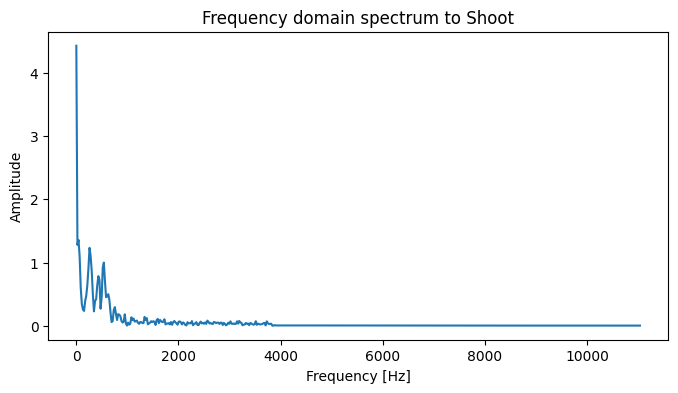

In [27]:
# SHOOT
plot_fft(shoot_sound, shoot_sr, audio_type='Shoot')

In [28]:
shoot_fft, shoot_mag = extract_fft(shoot_sound)

In [29]:
shoot_fft.shape

(1024,)

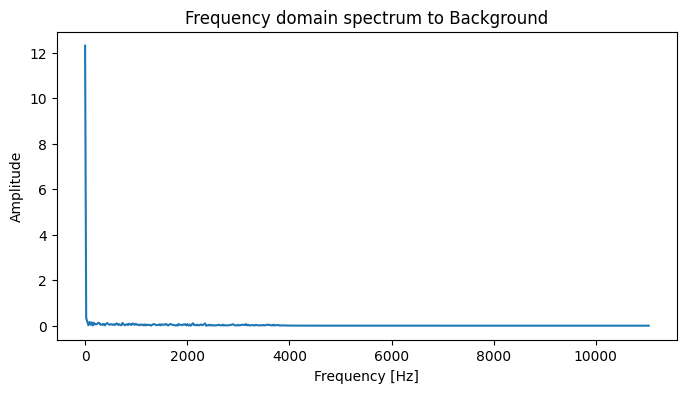

In [30]:
# BACKGROUND
plot_fft(back_sound, back_sr, audio_type='Background')

In [31]:
back_fft, back_mag = extract_fft(back_sound)

In [32]:
back_fft.shape

(1024,)

In [33]:
back_mag.shape

(1024,)

### Spectrogram

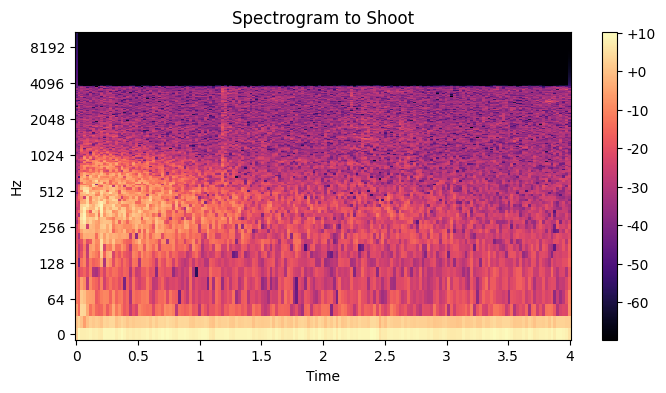

In [34]:
# SHOOT
plot_spectrogram(shoot_sound, y_axis='log', audio_type='Shoot')

In [35]:
shoot_spectrogram = extract_spectrogram(shoot_sound)
shoot_spectrogram.shape

(513, 173)

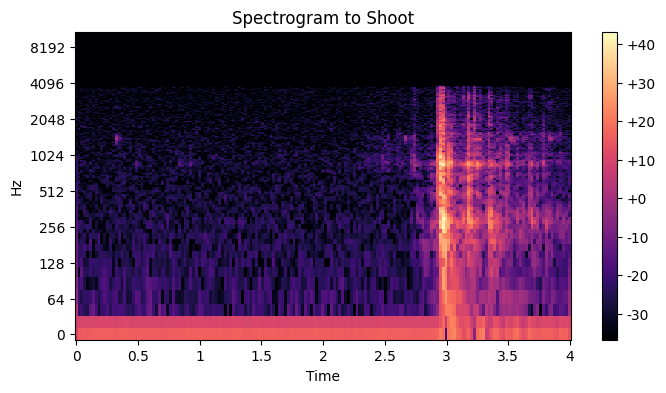

In [36]:
# BACKGROUND
plot_spectrogram(back_sound, y_axis='log', audio_type='Shoot')

In [37]:
back_spectrogram = extract_spectrogram(back_sound)
back_spectrogram.shape

(513, 173)

### Mel spectrogram

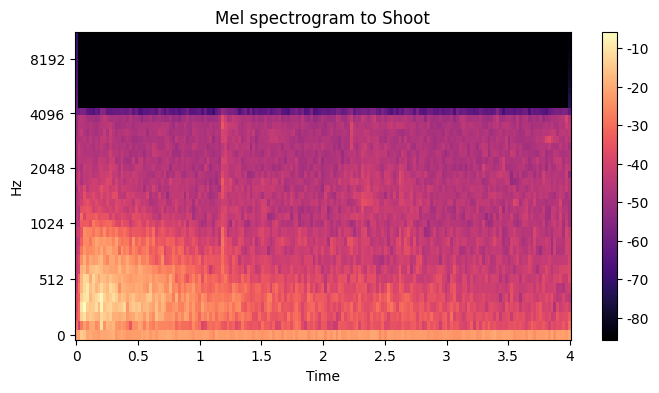

In [38]:
# SHOOT
plot_mel_spectrogram(shoot_sound, shoot_sr, audio_type='Shoot')

In [39]:
shoot_mel_spectrogram = extract_mel_spectrogram(shoot_sound, sr=shoot_sr)
shoot_mel_spectrogram.shape

(40, 173)

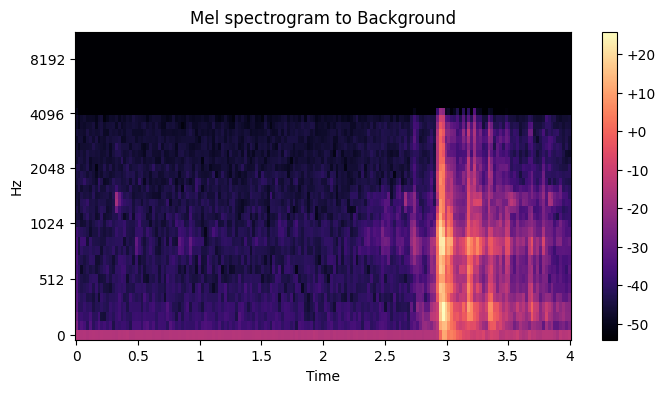

In [40]:
# BACKGROUND
plot_mel_spectrogram(back_sound, back_sr, audio_type='Background')

In [41]:
back_mel_spectrogram = extract_mel_spectrogram(back_sound, back_sr)
back_mel_spectrogram.shape

(40, 173)

### Mel-Frequency Cepstral

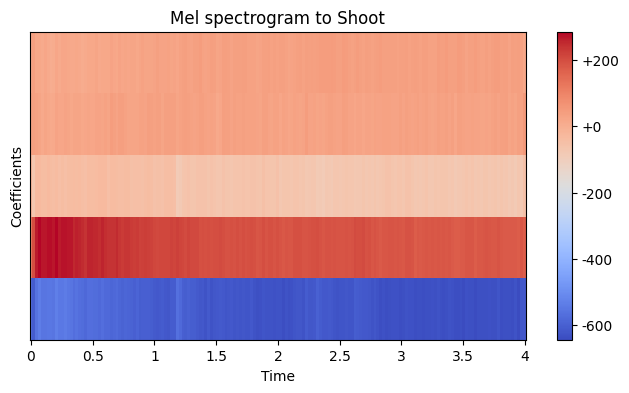

In [42]:
# Shoot
plot_mfcc(shoot_sound, shoot_sr, 'Shoot')

In [43]:
shoot_mfcc = extract_mfccs(shoot_sound, shoot_sr)
shoot_mfcc.shape

(5, 173)

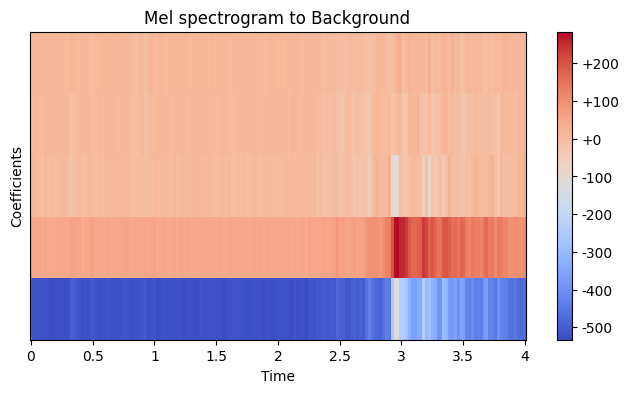

In [44]:
# Background
plot_mfcc(back_sound, back_sr, 'Background')

In [45]:
back_mfcc = extract_mfccs(back_sound, back_sr)
back_mfcc.shape

(5, 173)

# Prepare dataset

In [46]:
DATASET_PATH = '/content/Audios_disparos_selva/val'
TRAIN_JSON_PATH = 'train_data.json'
VAL_JSON_PATH = 'val_data.json'
SAMPLE_RATE = 22050
NUM_SEGMENTS = 5
DURATION = 4 # measured in seconds
SAMPLES_PER_TRACK = DURATION * SAMPLE_RATE

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=N_MFCC, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, num_segments=NUM_SEGMENTS):

  # dictionary to store data
  data = {
      'mapping': [],
      'mfcc': [],
      'labels': []
  }

  samples_per_segment = SAMPLES_PER_TRACK // num_segments
  expected_num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

  # loop through all the audios types (shoot and background)
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):

    # ensure that we're not at the root level
    if dirpath != DATASET_PATH:

      # save the semantic label
      semantic_label = dirpath.split('/')[-1] # shoot or background
      data['mapping'].append(semantic_label)
      print("\nProcessing: {}".format(semantic_label))

      # process file for specific audio type
      for f in filenames:

        # load audio file
        file_path = os.path.join(dirpath, f)
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # process segments extracting mfcc and storing data
        for s in range(num_segments):

          start_sample = samples_per_segment * s
          finish_sample = start_sample + samples_per_segment

          segment = signal[start_sample:finish_sample]

          # Each column represents the MFCCs of each segment
          mfcc = extract_mfccs(segment, sr).T.tolist()

          # store mfcc for segment if it has the expected length
          if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc)
            data["labels"].append(i-1)
            print("{}, segment: {}".format(file_path, s+1))

  # save MFCCs to json file
  with open(json_path, "w") as fp:
      json.dump(data, fp, indent=2)


In [ ]:
save_mfcc(DATASET_PATH, TRAIN_JSON_PATH)

In [ ]:
save_mfcc(DATASET_PATH, VAL_JSON_PATH)

## Load JSON from drive

In [47]:
train_drive_path = '/content/drive/MyDrive/json_to_tfi/train_data.json'
val_drive_path = '/content/drive/MyDrive/json_to_tfi/val_data.json'

In [48]:
def load_data(dataset_path):
  with open(dataset_path, 'r') as fp:
    data = json.load(fp)

  # convert lists into numpy arrays
  inputs = np.array(data["mfcc"])
  targets = np.array(data["labels"])

  return inputs, targets

In [49]:
inputs, targets = load_data(train_drive_path)

## Split the data into train and test sets

In [69]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets,
                                                    shuffle=True, test_size=0.3)

In [70]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (19418, 35, 5), Test shape: (8322, 35, 5)


In [71]:
print(f"Train shape: {y_train.shape}, Test shape: {y_test.shape}")

Train shape: (19418,), Test shape: (8322,)


# Implementing a Neural Network

## Only dense

In [56]:
model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

        # 1st hidden layer
        keras.layers.Dense(512, activation="relu"),

        # 2nd hidden layer
        keras.layers.Dense(256, activation="relu"),

        # 3rd hidden layer
        keras.layers.Dense(64, activation="relu"),

        # output layer
        keras.layers.Dense(2, activation="sigmoid")
        ])

## Compile network

In [72]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 175)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               90112     
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 238018 (929.76 KB)
Trainable params: 238018 (929.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=20,
          batch_size=64)

Epoch 1/20
304/304 [==============================] - 6s 19ms/step - loss: 0.4581 - accuracy: 0.9613 - val_loss: 0.2232 - val_accuracy: 0.9532
Epoch 2/20
304/304 [==============================] - 2s 8ms/step - loss: 0.1497 - accuracy: 0.9715 - val_loss: 0.3674 - val_accuracy: 0.9507
Epoch 3/20
304/304 [==============================] - 2s 8ms/step - loss: 0.1387 - accuracy: 0.9735 - val_loss: 0.2083 - val_accuracy: 0.9534
Epoch 4/20
304/304 [==============================] - 2s 8ms/step - loss: 0.1230 - accuracy: 0.9753 - val_loss: 0.2779 - val_accuracy: 0.9520
Epoch 5/20
304/304 [==============================] - 3s 9ms/step - loss: 0.1136 - accuracy: 0.9769 - val_loss: 0.1970 - val_accuracy: 0.9526
Epoch 6/20
304/304 [==============================] - 5s 15ms/step - loss: 0.1063 - accuracy: 0.9773 - val_loss: 0.3440 - val_accuracy: 0.9515
Epoch 7/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0965 - accuracy: 0.9779 - val_loss: 0.2094 - val_accuracy: 0.9546
Epoc

## evaluate model on val set

In [64]:
val_inputs, val_targets = load_data(val_drive_path)

In [65]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(val_inputs, val_targets, verbose=2)
print('\nTest accuracy:', test_acc)

867/867 - 3s - loss: 0.1170 - accuracy: 0.9768 - 3s/epoch - 3ms/step

Test accuracy: 0.9767844080924988
